# Enabling easy image printing in ipynb notebook

In [31]:
import cv2
import numpy as np

print(f"OpenCV version is: {cv2.__version__}")

if True:  # change to True if you want to use the notebook locally
    # and use cv2_imshow from matplotlib (eg. Vscode)
    import matplotlib.pyplot as plt

    def cv2_imshow(img):
        plt.figure(figsize=(10,10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

OpenCV version is: 4.10.0


# Task 1

# Code i used to confirm what are the ids of aruco tags 

In [32]:
GREEN = (0, 255, 0)
RED = (0, 0, 255)

def draw_quadrilateral(img, p_list, color, girth):
    shifted = np.concat([p_list[-1:],p_list[:-1]]).astype(int)
    zip_list = list(zip(p_list, shifted))

    for (p1, p2) in zip_list:
        cv2.line(img, p1, p2, color, girth)

def draw_square(img, p1, p3, color, girth):
    p_matrix = np.vstack([p1, p3])
    new = (p_matrix * np.eye(2), p_matrix * np.array([0,1,1,0]).reshape(2,2))

    p2, p4 = list(map(lambda x: x[np.nonzero(x)], new))
    p4 = p4[::-1]

    p_list = np.array([p1, p2, p3, p4]).astype(int)
    draw_quadrilateral(img, p_list, color, girth)

def drawMarkers(img, corners, ids):
    if ids is None:
        return

    square_size = 7
    for i in range(ids.shape[0]):
        c = corners[i][0]
        id = ids[i][0]
        draw_quadrilateral(img, c.astype(int), GREEN, 1)
        draw_square(img, c[0] - (square_size // 2), c[0] + (square_size // 2), RED, 1)
        cv2.putText(img, f"{id}", c[0].astype(int), cv2.FONT_HERSHEY_SIMPLEX, 1, RED, 2)

In [33]:
def input_parse(img = None, filename = None):
    if filename is not None:
        current = cv2.imread(filename)
    elif img is not None:
        current = img
    else:
        assert False

    return current

In [34]:
def get_objpoints(shape, width, uniform_grid = True):
    x, y = shape

    if uniform_grid:
        arr1 = np.linspace(0, width * x, x + 1), 
        arr2 = np.linspace(0, width * y, y + 1)
    else:
        arr1, arr2 = [0], [0]
        for i in range(x):
            arr1.append(arr1[i] + width[i % len(width)])
        for i in range(y):
            arr2.append(arr2[i] + width[i % len(width)])

    xx, yy = np.meshgrid(arr1, arr2)
    xx, yy = xx.reshape(-1), yy.reshape(-1)
    objarr = np.vstack([xx, yy, np.zeros(len(xx))]).T

    return objarr.astype(np.float32)

def get_marker_objp(width):
    objp = get_objpoints((1,1), width)
    objp[[2,3]] = objp[[3,2]]
    return objp

get_objpoints((3,5), [168, 70], False)
''

''

# Functions i use to retrieve properly permuted grid image point list

In [35]:
IDS_ORDERING = [29, 28, 24, 23, 19, 18]

def permute_ids_corners(ids, corners):
    ids = ids.reshape(-1)

    ids_order = np.argsort(ids)
    ids = ids[ids_order][::-1]
    corners = corners[ids_order][::-1] 

    return ids.reshape(-1, 1), corners

def find_aruco_info(img = None, filename = None):
    img = input_parse(img, filename)
    
    dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_16h5)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, parameters)

    corners, ids, _ = detector.detectMarkers(img)

    # img_ = img.copy()
    # drawMarkers(img_, corners, ids)
    # cv2_imshow(img_)

    corners = np.array(list(corners)).reshape(-1,4,1,2)

    if np.any(IDS_ORDERING != ids.reshape(-1)):
        ids, corners = permute_ids_corners(ids, corners)

    return (corners, ids)

def permute_corners(corners):
    corners = corners.reshape(-1,1,2)
    perm = np.array([0,1,4,5,3,2,7,6])
    coords = np.arange(len(perm))

    for i in range(3):
        corners[coords + (i * len(perm))] = corners[perm + (i * len(perm))]

    return corners

find_aruco_info(filename = 'data1/img17.png')
''

''

In [36]:
TAG_SIDE=168
SPACING=70
TAG_GRID=(3,5)

def calibrate(img = None, filename = None, use_grid = False):
    current = input_parse(img, filename)

    gray = cv2.cvtColor(current, cv2.COLOR_BGR2GRAY)

    corners = find_aruco_info(img = current)[0]
    if use_grid:
        corners = [permute_corners(corners)]
        objpoints = [get_objpoints(TAG_GRID, [TAG_SIDE, SPACING], False)]
    else:
        objpoints = [get_marker_objp(TAG_SIDE)] * 6

    calibration_res = cv2.calibrateCamera(
        objectPoints = objpoints,
        imagePoints = corners,
        imageSize = gray.shape[::-1],
        cameraMatrix = None,
        distCoeffs = None,
    )

    return (
        calibration_res,
        objpoints,
        corners,
    )

calibrate(filename = 'data1/img2.png', use_grid = True)
''


''

In [37]:
def get_projection_error(cMat, dCoeff, rvecs, tvecs, objpoints, imgpoints):
    total_error = 0
    total_points = 0

    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(
            objpoints[i],
            rvecs[i],
            tvecs[i],
            cMat,
            dCoeff,
        )

        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)
        total_error += error ** 2
        total_points += len(objpoints[i]) 

    mean_error = np.sqrt(total_error / total_points)
    return mean_error

In [38]:
def get_undistort_rectify(img = None, filename = None, use_grid = False, alpha = 0):
    current = input_parse(img, filename)

    gray = cv2.cvtColor(current, cv2.COLOR_BGR2GRAY)
    size = gray.shape[::-1]

    cal = calibrate(img = current, use_grid = use_grid)
    ((_, cMat, dCoeff, rvecs, tvecs), oP, iP) = cal

    projection_error = get_projection_error(cMat, dCoeff, rvecs, tvecs, oP, iP)

    newCMat, _ = cv2.getOptimalNewCameraMatrix(
        cameraMatrix = cMat,
        distCoeffs = dCoeff,
        imageSize = size,
        alpha = alpha,
        newImgSize = size,
    )

    undistort, rectify = cv2.initUndistortRectifyMap(
        cameraMatrix = cMat,
        distCoeffs = dCoeff,
        R = np.eye(3),
        newCameraMatrix = newCMat,
        size = size,
        m1type = cv2.CV_32FC1,
    )

    return (undistort, rectify, projection_error)

In [39]:
def undistort(img = None, filename = None, use_grid = False, alpha = 0):
    current = input_parse(img, filename)

    (undistort, rectify, err) = get_undistort_rectify(
        img = current,
        use_grid = use_grid,
        alpha = alpha,
    )

    print(f"Mean reprojection error : {err}")

    undistorted = cv2.remap(
        src = current,
        map1 = undistort,
        map2 = rectify,
        interpolation = cv2.INTER_LINEAR,
    )

    return undistorted

# Comparing calibration on a single image

Original image:


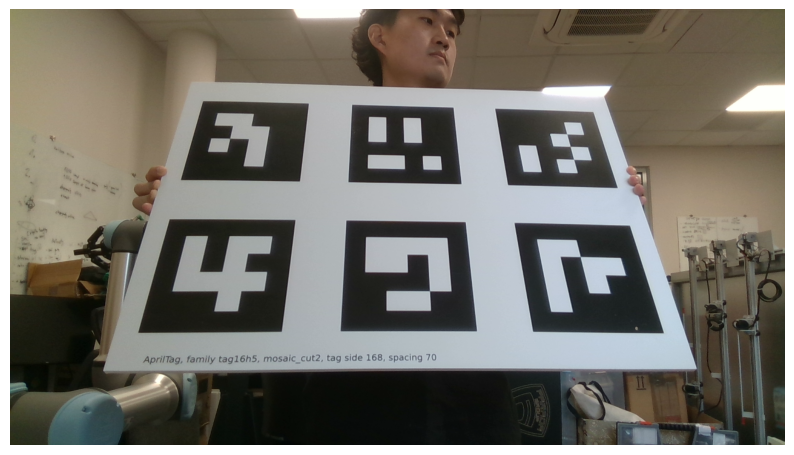

With grid usage:
Mean reprojection error : 0.724053075479598


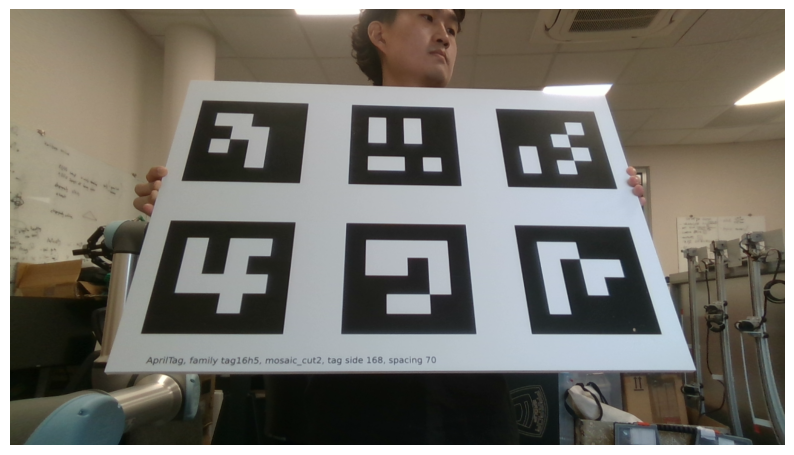

Without grid usage:
Mean reprojection error : 0.1750859712343675


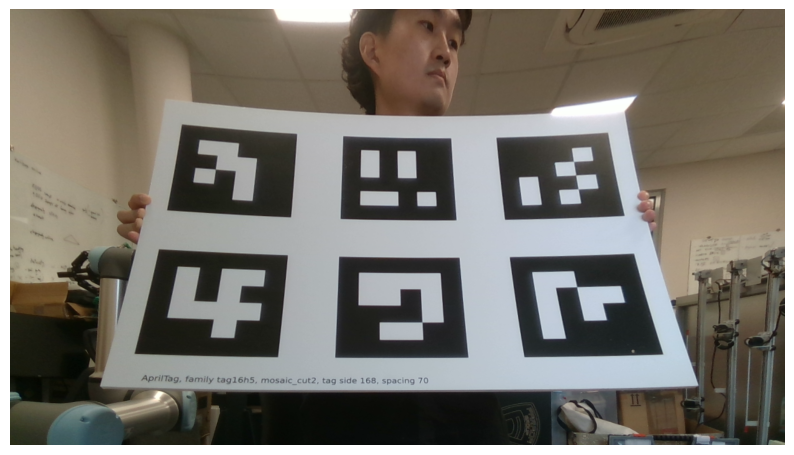

In [40]:
used_img = 'data1/img17.png'

print("Original image:")
cv2_imshow(cv2.imread(used_img))
print("With grid usage:")
img = undistort(filename = used_img, use_grid = True)
cv2_imshow(img)
print("Without grid usage:")
img = undistort(filename = used_img, use_grid = False)
cv2_imshow(img)

# Comment on the results

I checked if the lines are straight on images produced by both methods and on the original image. In my opinion, the image produced with all available information is clearly superior. The edges of the board are really straight, and when you flip between undistorded and original image, you can actually see the distosion.

However, that method also results with higher reprojection error. This might be because i made a mistake, but on the other hand it also makes sense. It is easier to make 6 different transformations to fit 6 sets of points, than making one that should fit all the points combined.

# Task 2

# Calibrate camera on all images using all available data (grid method)

In [79]:
def calibrate_all():
    TAG_SIDE=168
    SPACING=70
    TAG_GRID=(3,5)

    all_files = [f'data1/img{i}.png' for i in range(1,29)]
    imgs = [cv2.imread(f) for f in all_files]

    corners = [find_aruco_info(img = i)[0] for i in imgs]
    permuted = [permute_corners(cor) for cor in corners]

    objpoints = [get_objpoints(TAG_GRID, [TAG_SIDE, SPACING], False)]
    objpoints = objpoints * len(imgs)

    inliners = []
    for o, p in list(zip(objpoints, permuted)):
        calibration_res = cv2.calibrateCamera(
            objectPoints = [o],
            imagePoints = [p],
            imageSize = imgs[0].shape[:2][::-1],
            cameraMatrix = None,
            distCoeffs = None,
        )

        if(calibration_res[0] < 0.8):
            inliners.append((o, p))

    obj, perm = zip(*inliners)    
    calibration_res = cv2.calibrateCamera(
        objectPoints = obj,
        imagePoints = perm,
        imageSize = imgs[0].shape[:2][::-1],
        cameraMatrix = None,
        distCoeffs = None,
    )

    return calibration_res[1:3]

In [80]:
def undistort_all():
    cMat, dCoeff = calibrate_all()

    all_files = [f'data2/img{i}.png' for i in range(1,10)]
    imgs = [cv2.imread(f) for f in all_files]
    size = imgs[0].shape[:2][::-1]

    newCMat, _ = cv2.getOptimalNewCameraMatrix(
        cameraMatrix = cMat,
        distCoeffs = dCoeff,
        imageSize = size,
        alpha = 1,
        newImgSize = size,
    )

    undistort, rectify = cv2.initUndistortRectifyMap(
        cameraMatrix = cMat,
        distCoeffs = dCoeff,
        R = np.eye(3),
        newCameraMatrix = newCMat,
        size = size,
        m1type = cv2.CV_32FC1,
    )

    for current, name in list(zip(imgs, all_files)):
        new_name = 'data3' + name[5:]

        undistorted = cv2.remap(
            src = current,
            map1 = undistort,
            map2 = rectify,
            interpolation = cv2.INTER_LINEAR,
        )

        cv2.imwrite(new_name, undistorted) 

undistort_all()

In [49]:
def find_span(coords):
    col = coords[:, 0]
    xspan = [np.min(col), np.max(col)]
    col = coords[:, 1]
    yspan = [np.min(col), np.max(col)]
    return np.vstack([xspan, yspan])

def multiply_normalize(mA, mB):
    res = mA @ mB 
    last_row = res[-1, :] 
    res_norm = res / last_row

    return res_norm

def multiply_coords_matrix(range_x, range_y, matrix):
    xx, yy = np.meshgrid(np.arange(*range_x), np.arange(*range_y))
    length = (range_x[1] - range_x[0]) * (range_y[1] - range_y[0])
    stack_list = [xx.flatten(), yy.flatten(), np.ones(length)]
    xy1_vectors = np.stack(stack_list, axis=1).astype(int)

    new_coords = multiply_normalize(matrix, xy1_vectors.T)
    new_coords = np.round(new_coords).astype(int)
    return new_coords

def transform(tx, ty, matrix):
    transform_matrix = np.array([1,0,tx,0,1,ty,0,0,1]).reshape(3,3)
    new_coords = transform_matrix @ matrix
    last_row = new_coords[-1, :] 
    new_coords = np.round(new_coords / last_row).astype(int)
    return new_coords

In [50]:
def pixel_list_to_img(w, h, array):
    array = array.reshape(w, h, 3)
    return array.astype(np.uint8)

def cut_to_dimensions(width, heigth, matrix):
    xs, ys = matrix[:, 0], matrix[:, 1]
    xl, yl = xs < 0, ys < 0
    xu, yu = xs >= width, ys >= heigth
    cond = np.any(np.vstack([xl, yl, xu, yu]), axis = 0)
    matrix[cond] = [0, heigth]

    return matrix.astype(int)

def find_colors(point_coords, img):
    _, w, _ = img.shape
    black_row = np.zeros((1, w, 3), dtype=np.uint8)
    img = np.vstack([img, black_row])
    x_coords, y_coords = point_coords[:, 0], point_coords[:, 1]

    return img[y_coords, x_coords]

(720, 1280, 3)
(719, 807, 3)


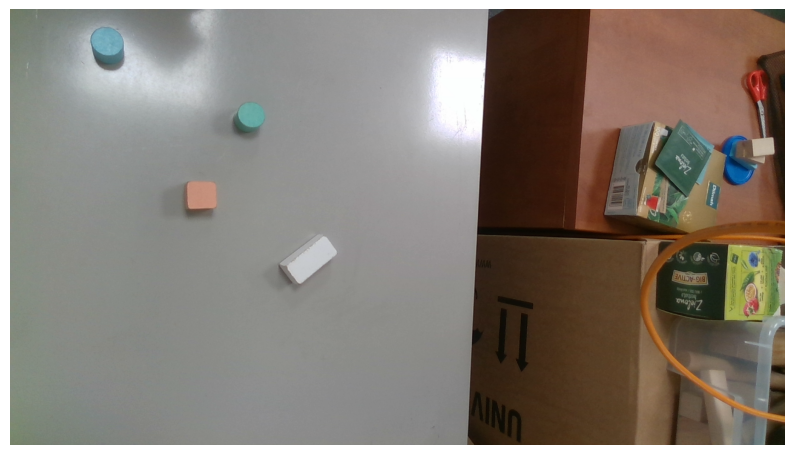

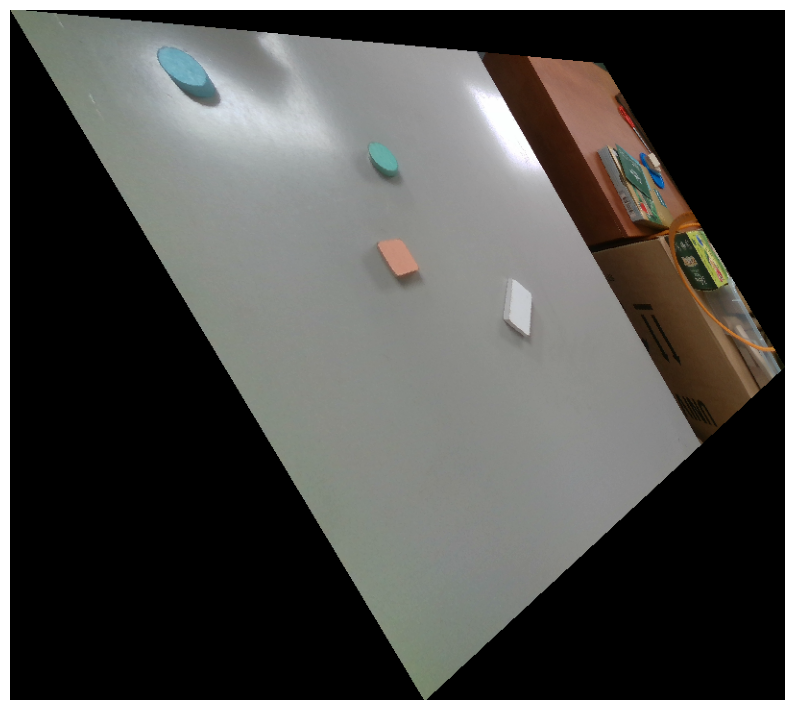

In [51]:
def apply_homography(homography, filename = None, img = None):
    current = input_parse(img, filename)

    h, w, _ = current.shape

    new_coords = multiply_coords_matrix([0,w], [0,h], homography).T 

    span = find_span(new_coords)
    new_h, new_w = list(span[:, 1] - span[:, 0])

    inv_homography = np.linalg.inv(homography)
    original_cords = multiply_coords_matrix(span[0, :], span[1, :], inv_homography)
    original_cords = original_cords.T
    original_cords = cut_to_dimensions(w, h, original_cords[:, [0,1]])
    
    new_colors = find_colors(original_cords, current)
    new_image = pixel_list_to_img(new_w, new_h, new_colors)
    print(current.shape)
    print(new_image.shape)
    cv2_imshow(current)
    cv2_imshow(new_image)

def img_identity(img):
    current = img
    h, w, _ = current.shape

    new_coords = multiply_coords_matrix(w, h, np.eye(3)).T
    new_colors = find_colors(new_coords, current)
    new_image = pixel_list_to_img(w, h, new_colors)

    cv2_imshow(new_image)

imgpath = 'data2/img1.png'
trapezoid_homography = np.array([1,0.6,-100,0,1,-100,0.001,0,1]).reshape(3,3)
apply_homography(filename=imgpath, homography = trapezoid_homography)

In [52]:
def intertwine(even, odd):
    if isinstance(even, np.ndarray):
        length = 2 * np.array(even).shape[0] 
    elif isinstance(odd, np.ndarray):
        length = 2 * np.array(odd).shape[0] 
    else:
        return None

    matrix = np.zeros(length)
    matrix[0::2] = even
    matrix[1::2] = odd
    return matrix.reshape(-1,1)

def find_A_matrix(source_points, dest_points):
    xs, ys = source_points[:, 0], source_points[:, 1]
    xd, yd = dest_points[:, 0], dest_points[:, 1]
    n, _ = source_points.shape 
    A_rows = [
        intertwine(xs, 0),
        intertwine(ys, 0),
        intertwine(1, np.zeros(n)),
        intertwine(0, xs),
        intertwine(0, ys),
        intertwine(np.zeros(n), 1),
        intertwine(-1 * xd * xs, -1 * yd * xs),
        intertwine(-1 * xd * ys, -1 * yd * ys),
        intertwine(-1 * xd, -1 * yd)
    ]

    A_matrix = np.hstack(A_rows)
    return A_matrix

In [53]:
# val, vec = np.linalg.eig(A_matrix.T @ A_matrix)
# print(val)
# homography_eig = vec[:, np.argmin(val)].reshape(3, 3)

# cvhom, _ = cv2.findHomography(source_points, dest_points, method=cv2.LMEDS)

# for homography in [homography_svd, homography_eig, cvhom]:
#     print(homography, end='\n\n')

#     ones = np.ones((len(source_points), 1))
#     new_dest = multiply_normalize(
#         homography,
#         np.hstack([source_points, ones]).T,
#     ).T

#     print(np.hstack([dest_points, new_dest[:, [0,1]]]).astype(np.float16))

In [54]:
def find_homography(source_points, dest_points):
    A_matrix = find_A_matrix(source_points, dest_points)

    _, _, V = np.linalg.svd(A_matrix)
    smallest_eingenvector = V[-1, :]
    homography = smallest_eingenvector.reshape(3, 3)

    # normalize
    return homography / homography[-1, -1]

In [55]:
def translation_M(tx, ty):
    return np.array([1,0,tx,0,1,ty,0,0,1]).reshape(3,3)

def rot_M(axis, phi):
    c = np.cos(phi)
    s = np.sin(phi)
    
    if axis == 0:
        a = [1, 0, 0, 0, c, -s, 0, s, c]
    elif axis == 1:
        a = [c, 0, -s, 0, 1, 0, s, 0, c]
    elif axis == 2:
        a = [c, -s, 0, s, c, 0, 0, 0, 1]
    else:
        return None
    return np.array(a).reshape(3,3)

def scale_M(sx, sy):
    return np.array([sx,0,0,0,sy,0,0,0,1]).reshape(3,3)

In [56]:
def random_homography():
    srange = [0.3, 1.7]
    sx, sy = np.random.uniform(*srange), np.random.uniform(*srange)
    
    trange = [-200, 200]
    tx, ty = np.random.uniform(*trange), np.random.uniform(*trange)

    hrange = [0.5e-3, 1e-4]    
    h31, h32 = np.random.uniform(*hrange), np.random.uniform(*hrange)
    h31, h32 = h31 * np.random.choice([-1,1]), h32 * np.random.choice([-1,1])

    axis = np.random.choice([0,1,2])
    phi = np.random.uniform(0, 2 * np.pi)

    ops = [
        scale_M(sx, sy),
        translation_M(tx, ty),
        rot_M(axis, phi)
    ]

    homography = np.eye(3)
    for i in np.random.permutation(3):
        homography @= ops[i]

    homography[2, :] = [h31, h32, 1]

    lower, upper = 0.1, 10
    det = np.abs(np.linalg.det(homography))
    if upper > det > lower:
        return homography
    else:
        return random_homography()

#homography = random_homography()
#apply_homography(filename=imgpath, homography = homography)

In [57]:
def test_find_homography(tests = 10, points = 4):
    for _ in range(tests):
        prange = [0, 100]
        x = np.random.uniform(*prange, points).astype(int)
        y = np.random.uniform(*prange, points).astype(int)
        source = np.vstack([x, y])

        RH = random_homography()
        dest = multiply_normalize(RH, np.vstack([source, np.ones(points)]))

        FH = find_homography(source.T, dest.T)

        error = cv2.norm(RH, FH, cv2.NORM_L2)
        assert error < 1e-5

test_find_homography()

In [ ]:
path = 'data2/img1.png'
img = cv2.imread(path)
cv2.imshow(path, img)
cv2.waitKey(0)
cv2.destroyAllWindows()

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/nojak/Git/ML-stuff/venv/lib/python3.12/site-packages/cv2/qt/plugins"
